# Setup altimetry from probe data

This is the standard use case for altimetry module.

For consulting cases, the probes are defined in the intersection between the section and the sheds.
The sections are defined in the planning phase of the consulting project, from the implantation.
The implantation image comes from client data.


## Read probe data

Refer to altimetry module for probes table format.

Read probe data from a csv and create altimetry probes from it.
It should contain all the information needed for this module purpose.


In [1]:
import pathlib
from cfdmod.use_cases.altimetry import AltimetryProbe, AltimetrySection, Shed

csv_path = pathlib.Path("./fixtures/tests/probes.csv")
probes = AltimetryProbe.from_csv(csv_path)
probes[:10]

[AltimetryProbe(probe_coordinate=(193.0, 167.0, 830.0), building_label='GB', section_label='G', probe_label='GB-000-G', case_label='0'),
 AltimetryProbe(probe_coordinate=(193.0, 122.0, 830.0), building_label='GB', section_label='H', probe_label='GB-000-H', case_label='0'),
 AltimetryProbe(probe_coordinate=(392.9, 77.0, 830.0), building_label='GA', section_label='I', probe_label='GA-000-I', case_label='0'),
 AltimetryProbe(probe_coordinate=(193.0, 77.0, 830.0), building_label='GB', section_label='I', probe_label='GB-000-I', case_label='0'),
 AltimetryProbe(probe_coordinate=(392.9, 32.0, 830.0), building_label='GA', section_label='J', probe_label='GA-000-J', case_label='0'),
 AltimetryProbe(probe_coordinate=(193.0, 32.0, 830.0), building_label='GB', section_label='J', probe_label='GB-000-J', case_label='0'),
 AltimetryProbe(probe_coordinate=(392.9, -13.0, 830.0), building_label='GA', section_label='K', probe_label='GA-000-K', case_label='0'),
 AltimetryProbe(probe_coordinate=(193.0, -13.

## Surface slicing

From a given surface in STL format (binary or ASCII), get the vertices that compose the profile generated by sectioning it.

The sections are defined by the input probe data.
The input surface represents the terrain of the client's implantation.
And the buildings cut by the section are also defined by the input probe data.


In [2]:
import trimesh

surface_mesh: trimesh.Trimesh = trimesh.load_mesh("./fixtures/tests/altimetry/terrain.stl")

sections = set([p.section_label for p in probes])
altimetry_list: list[AltimetrySection] = []  # For debug plotting purposes

for sec_label in sections:
    section_probes = [p for p in probes if p.section_label == sec_label]
    sheds_in_section = set([p.building_label for p in section_probes])
    shed_list: list[Shed] = []

    for shed_label in sheds_in_section:
        building_probes = sorted(
            [p for p in section_probes if p.building_label == shed_label],
            key=lambda x: (x.coordinate[0], x.coordinate[1]),
        )
        shed = Shed(
            start_coordinate=building_probes[0].coordinate,
            end_coordinate=building_probes[1].coordinate,
            shed_label=shed_label,
        )
        shed_list.append(shed)

    altimetry_section = AltimetrySection.from_points(
        sec_label, shed_list[0].start_coordinate, shed_list[0].end_coordinate
    )
    altimetry_section.slice_surface(surface_mesh)
    [altimetry_section.include_shed(s) for s in shed_list]

    altimetry_list.append(altimetry_section)

    print("Section: ", sec_label, "Buildings in section:", sheds_in_section)

Section:  G Buildings in section: {'GB'}
Section:  J Buildings in section: {'GA', 'GB'}
Section:  Y Buildings in section: {'GE'}
Section:  R Buildings in section: {'GD'}
Section:  V Buildings in section: {'GD'}
Section:  P Buildings in section: {'GD'}
Section:  A Buildings in section: {'GA'}
Section:  H Buildings in section: {'GB'}
Section:  I Buildings in section: {'GA', 'GB'}
Section:  Q Buildings in section: {'GD'}
Section:  D Buildings in section: {'GB'}
Section:  X Buildings in section: {'GD'}
Section:  M Buildings in section: {'GA'}
Section:  C Buildings in section: {'GA'}
Section:  L Buildings in section: {'GA'}
Section:  B Buildings in section: {'GA'}
Section:  T Buildings in section: {'GC'}
Section:  N Buildings in section: {'GC', 'GD', 'GE'}
Section:  U Buildings in section: {'GC'}
Section:  S Buildings in section: {'GD'}
Section:  F Buildings in section: {'GB'}
Section:  W Buildings in section: {'GD'}
Section:  E Buildings in section: {'GB'}
Section:  O Buildings in section:

## Plotting: Altimetry profiles

Altimetry profiles are 2D plots of the section and the buildings cut by it.
For each section defined by probe data, it is generated a section.

When using the code from this notebook, it is required to implement the logic to save the image since only the plotting is performed


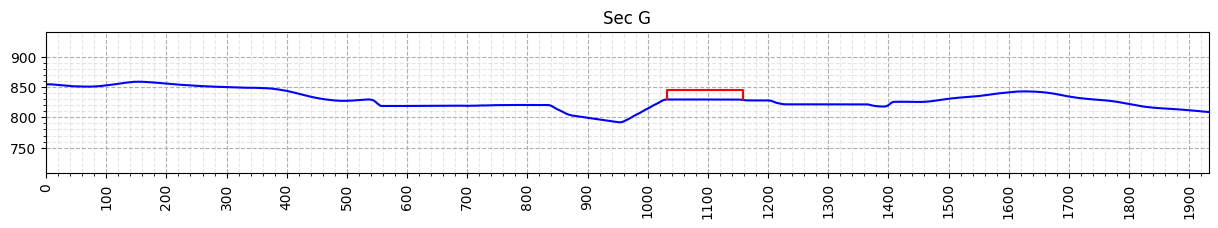

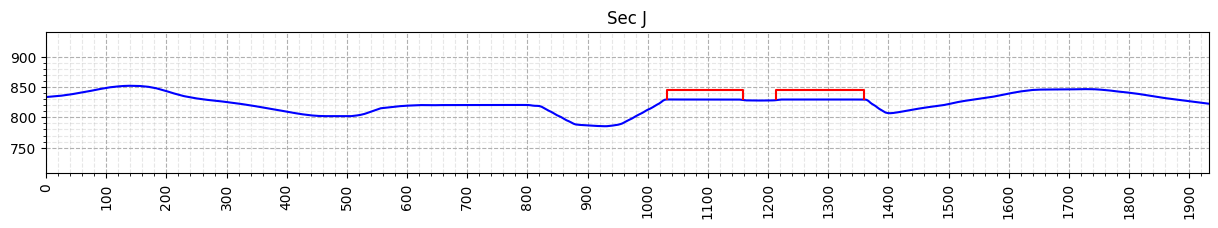

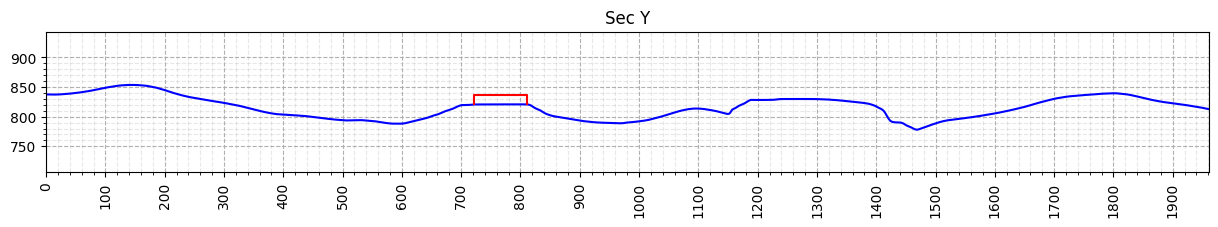

In [3]:
from cfdmod.use_cases.altimetry.plots import plot_surface, plot_profiles, plot_altimetry_profiles
import matplotlib.pyplot as plt

output_path = pathlib.Path("./output/altimetry")

# Plot only the first three profiles for examplification purposes
for altimetry_section in altimetry_list[:3]:
    fig, ax = plot_altimetry_profiles(altimetry_section)
    plt.show(fig)
    plt.close(fig)

## DEBUG Plotting: Surface

Plot to visualize where the sections are cutting the surface.


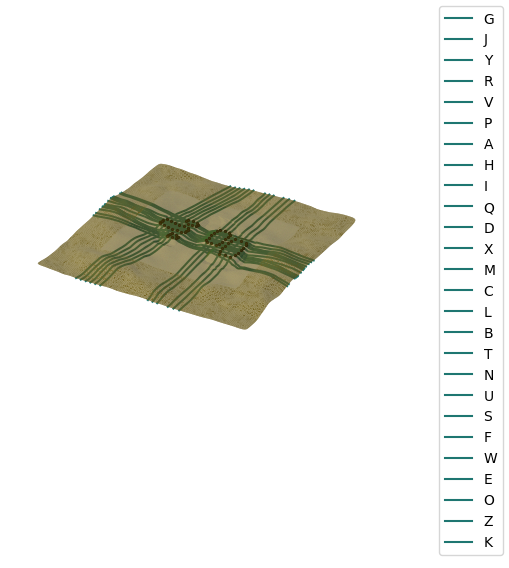

In [4]:
fig, ax = plot_surface(surface_mesh, altimetry_list)
plt.show(fig)
plt.close(fig)

## DEBUG Plotting: profiles

Plot to visualize the profiles generated.
It is only used for a quick scout if the projection of the sections are making sense.


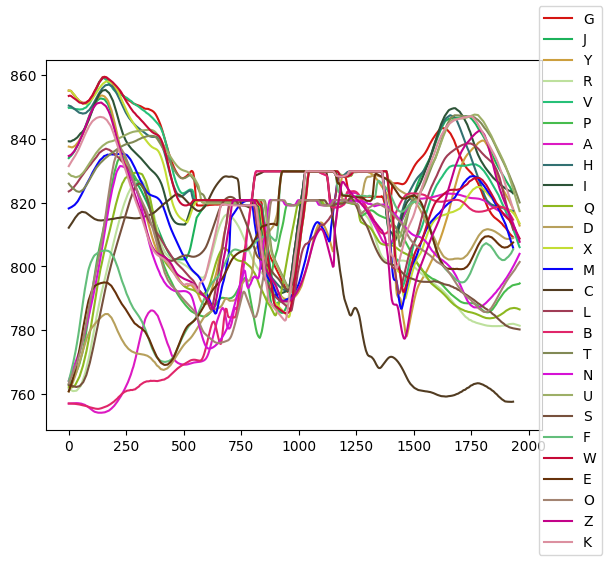

In [5]:
fig, ax = plot_profiles(altimetry_list)
plt.show(fig)
plt.close(fig)